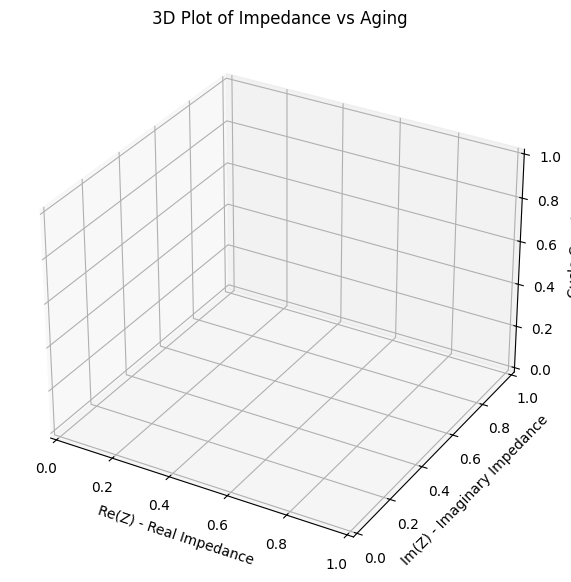

In [1]:
# 1.a)	From the given dataset, could you create a 3D plot from the EIS measurements showing how Impedance (R(Z) on X-axis, Inn(Z) on Y-axis) is changing w.r.t. Aging (Cycle count on Z axis) assuming Temperature, etc. to be the same. A sample EIS plot is shown below without the Z-axis.

import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dataset_path = "Downloads/assignment"

def load_eis_data(file_path):
    data = scipy.io.loadmat(file_path)
    real_impedance = data.get('Re_Z', []) 
    imag_impedance = data.get('Im_Z', [])  
    cycle_count = data.get('Cycle', [])  

    return real_impedance, imag_impedance, cycle_count

real_vals, imag_vals, cycles = [], [], []

for file in os.listdir(dataset_path):  
    if file.endswith(".mat"):
        file_path = os.path.join(dataset_path, file)  
        real_Z, imag_Z, cycle = load_eis_data(file_path) 
        
        if real_Z and imag_Z and cycle: 
            real_vals.extend(real_Z.flatten())  
            imag_vals.extend(imag_Z.flatten()) 
            cycles.extend(cycle.flatten())    

real_vals = np.array(real_vals)
imag_vals = np.array(imag_vals)
cycles = np.array(cycles)   

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(real_vals, imag_vals, cycles, c=cycles, cmap='viridis', marker='o')

# Labels and title
ax.set_xlabel('Re(Z) - Real Impedance')
ax.set_ylabel('Im(Z) - Imaginary Impedance')
ax.set_zlabel('Cycle Count')
ax.set_title('3D Plot of Impedance vs Aging')

plt.show()

C:\Users\mpshi\AppData\Local\Temp\ipykernel_9608\3001759431.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


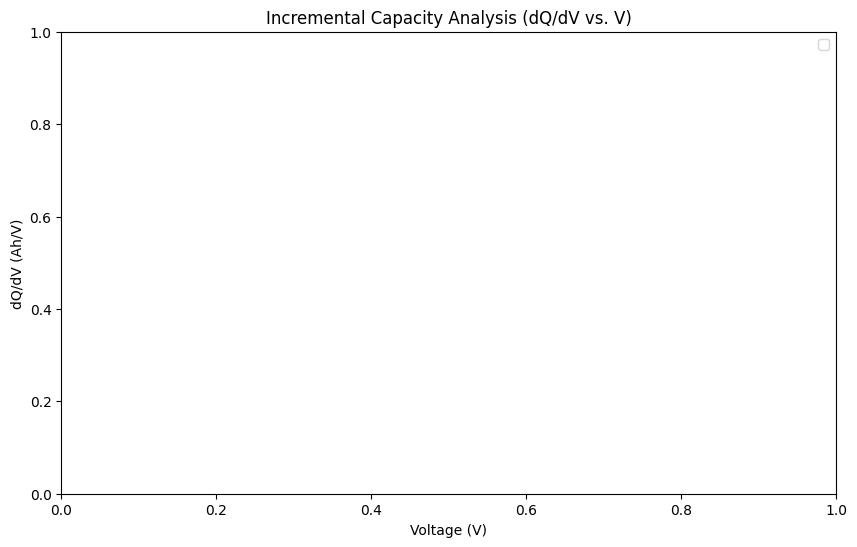

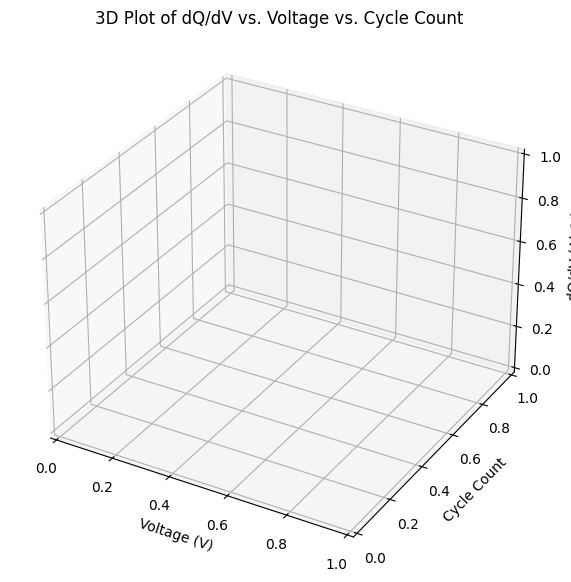

In [3]:
#2. Atypical charge/discharge cycle data for a battery cell looks like the plot below a).From a), could you derive plot b) for incremental capacity analysis showing dQ/dV versus V which indicates how the rate of capacity increment w.r.t. Voltage changes w.r.t. Voltage as the cell is charged or discharged?
#Couldyoucreatea3Dplotshowinghowpeaksinb)change w.r.t. Aging (cycle count).


import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


dataset_path = "Downloads/assignment"


def load_charge_discharge_data(file_path):
    data = scipy.io.loadmat(file_path)

   
    voltage = data.get('Voltage', []) 
    capacity = data.get('Capacity', []) 
    cycle_count = data.get('Cycle', [])

    return voltage, capacity, cycle_count

voltage_vals, capacity_vals, cycles = [], [], []

for file in os.listdir(dataset_path):
    if file.endswith(".mat"):
        file_path = os.path.join(dataset_path, file)
        voltage, capacity, cycle = load_charge_discharge_data(file_path)

        if voltage and capacity and cycle:
            voltage_vals.append(voltage.flatten())
            capacity_vals.append(capacity.flatten())
            cycles.append(cycle.flatten()[0]) 


voltage_vals = np.array(voltage_vals)
capacity_vals = np.array(capacity_vals)
cycles = np.array(cycles)


dq_dv = []
for i in range(len(voltage_vals)):
    dQ = np.diff(capacity_vals[i]) 
    dV = np.diff(voltage_vals[i])  
    dq_dv.append(dQ / dV) 


dq_dv = np.array(dq_dv)


plt.figure(figsize=(10, 6))
for i in range(len(dq_dv)):
    plt.plot(voltage_vals[i][1:], dq_dv[i], label=f'Cycle {cycles[i]}')

plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV (Ah/V)')
plt.title('Incremental Capacity Analysis (dQ/dV vs. V)')
plt.legend()
plt.show()


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(dq_dv)):
    ax.plot(voltage_vals[i][1:], dq_dv[i], zs=cycles[i], zdir='y', label=f'Cycle {cycles[i]}')

ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Cycle Count')
ax.set_zlabel('dQ/dV (Ah/V)')
ax.set_title('3D Plot of dQ/dV vs. Voltage vs. Cycle Count')

plt.show()


         




In [4]:
# 3. Could you train a machine learning model to predict the current capacity of the battery Cell from the current EIS signature?

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


metadata_path ="Downloads/assignment/cleaned_dataset/metadata.csv"
metadata_df = pd.read_csv(metadata_path)


metadata_df = metadata_df.dropna()


discharge_tests = metadata_df[metadata_df['type'] == 'discharge'][['filename', 'Capacity']]
discharge_tests['Capacity'] = pd.to_numeric(discharge_tests['Capacity'], errors='coerce')
discharge_tests = discharge_tests.dropna()


impedance_tests = metadata_df[metadata_df['type'] == 'impedance'][['filename', 'Re', 'Rct']]


impedance_tests['Re'] = impedance_tests['Re'].apply(lambda x: complex(str(x).replace(' ', '').replace('j', '')).real)
impedance_tests['Rct'] = impedance_tests['Rct'].apply(lambda x: complex(str(x).replace(' ', '').replace('j', '')).real)


merged_data = discharge_tests.merge(impedance_tests, on='filename')


print("Shape of discharge_tests:", discharge_tests.shape)
print("Head of discharge_tests:\n", discharge_tests.head())
print("\nShape of impedance_tests:", impedance_tests.shape)
print("Head of impedance_tests:\n", impedance_tests.head())
print("\nShape of merged_data:", merged_data.shape)  
print("Head of merged_data:\n", merged_data.head())


if merged_data.shape[0] > 0:
    X = merged_data[['Re', 'Rct']]
    y = merged_data['Capacity']

   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

   
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model Performance:\nRMSE: {np.sqrt(mse):.4f}\nR² Score: {r2:.4f}")
else:
    print("merged_data is empty. Check your data and merge conditions.")

Shape of discharge_tests: (0, 2)
Head of discharge_tests:
 Empty DataFrame
Columns: [filename, Capacity]
Index: []

Shape of impedance_tests: (0, 3)
Head of impedance_tests:
 Empty DataFrame
Columns: [filename, Re, Rct]
Index: []

Shape of merged_data: (0, 4)
Head of merged_data:
 Empty DataFrame
Columns: [filename, Capacity, Re, Rct]
Index: []
merged_data is empty. Check your data and merge conditions.
